In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [6]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [7]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [8]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [9]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [10]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [11]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [12]:
n_factors = 50

In [13]:
np.random.seed = 42

Randomly split into training and validation.

In [14]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [15]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [16]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [17]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [18]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [19]:
top_r.head()

,userId,movieId,rating,timestamp,rating_r,rating_r
962,14,417,2.0,997938310,1700,247
5048,29,417,4.0,944943070,1011,247
10214,72,417,5.0,1303464840,1610,247
28390,211,417,3.0,1218405007,876,247
29266,212,417,3.0,1462637445,910,247


In [20]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [21]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [22]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [23]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80024 samples, validate on 19980 samples
Epoch 1/1
80024/80024 [==============================] - 6s - loss: 9.8959 - val_loss: 3.8621


In [24]:
model.optimizer.lr=0.01

In [25]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80024 samples, validate on 19980 samples
Epoch 1/3
80024/80024 [==============================] - 6s - loss: 3.1270 - val_loss: 2.0357
Epoch 2/3
80024/80024 [==============================] - 6s - loss: 2.4230 - val_loss: 1.6699
Epoch 3/3
80024/80024 [==============================] - 6s - loss: 2.2649 - val_loss: 1.5370


In [26]:
model.optimizer.lr=0.001

In [27]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80024 samples, validate on 19980 samples
Epoch 1/6
80024/80024 [==============================] - 6s - loss: 2.2055 - val_loss: 1.4810
Epoch 2/6
80024/80024 [==============================] - 6s - loss: 2.1716 - val_loss: 1.4520
Epoch 3/6
80024/80024 [==============================] - 6s - loss: 2.1418 - val_loss: 1.4431
Epoch 4/6
80024/80024 [==============================] - 6s - loss: 2.1148 - val_loss: 1.4408
Epoch 5/6
80024/80024 [==============================] - 6s - loss: 2.0900 - val_loss: 1.4344
Epoch 6/6
80024/80024 [==============================] - 6s - loss: 2.0642 - val_loss: 1.4451


In [28]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [29]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [30]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [31]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [32]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [33]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
# how do these vectors merge if they have different lengths, embeddings are intelligent
# they are only a row of the matrix, not more
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [34]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80024 samples, validate on 19980 samples
Epoch 1/1
80024/80024 [==============================] - 5s - loss: 8.8819 - val_loss: 3.2641


In [35]:
model.optimizer.lr=0.01

In [36]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80024 samples, validate on 19980 samples
Epoch 1/6
80024/80024 [==============================] - 5s - loss: 2.6070 - val_loss: 1.6607
Epoch 2/6
80024/80024 [==============================] - 5s - loss: 1.9811 - val_loss: 1.3445
Epoch 3/6
80024/80024 [==============================] - 5s - loss: 1.8112 - val_loss: 1.2277
Epoch 4/6
80024/80024 [==============================] - 6s - loss: 1.7140 - val_loss: 1.1790
Epoch 5/6
80024/80024 [==============================] - 6s - loss: 1.6348 - val_loss: 1.1353
Epoch 6/6
80024/80024 [==============================] - 6s - loss: 1.5599 - val_loss: 1.1045


In [37]:
model.optimizer.lr=0.001

In [38]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80024 samples, validate on 19980 samples
Epoch 1/10
80024/80024 [==============================] - 5s - loss: 1.4885 - val_loss: 1.0762
Epoch 2/10
80024/80024 [==============================] - 5s - loss: 1.4213 - val_loss: 1.0531
Epoch 3/10
80024/80024 [==============================] - 6s - loss: 1.3549 - val_loss: 1.0313
Epoch 4/10
80024/80024 [==============================] - 5s - loss: 1.2937 - val_loss: 1.0105
Epoch 5/10
80024/80024 [==============================] - 5s - loss: 1.2329 - val_loss: 0.9846
Epoch 6/10
80024/80024 [==============================] - 6s - loss: 1.1747 - val_loss: 0.9661
Epoch 7/10
80024/80024 [==============================] - 5s - loss: 1.1196 - val_loss: 0.9440
Epoch 8/10
80024/80024 [==============================] - 5s - loss: 1.0655 - val_loss: 0.9259
Epoch 9/10
80024/80024 [==============================] - 5s - loss: 1.0146 - val_loss: 0.9087
Epoch 10/10
80024/80024 [==============================] - 6s - loss: 0.9663 - val_loss: 0.8892

In [39]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80024 samples, validate on 19980 samples
Epoch 1/5
80024/80024 [==============================] - 5s - loss: 0.9206 - val_loss: 0.8723
Epoch 2/5
80024/80024 [==============================] - 5s - loss: 0.8777 - val_loss: 0.8614
Epoch 3/5
80024/80024 [==============================] - 5s - loss: 0.8374 - val_loss: 0.8476
Epoch 4/5
80024/80024 [==============================] - 6s - loss: 0.8014 - val_loss: 0.8336
Epoch 5/5
80024/80024 [==============================] - 5s - loss: 0.7669 - val_loss: 0.8249


In [40]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [41]:
model.save_weights(model_path+'bias.h5')

In [42]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [43]:
model.predict([np.array([3]), np.array([6])])

array([[ 5.2431]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [44]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [45]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [46]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.36473876, 'Battlefield Earth (2000)'),
 (-0.14925072, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.044196561, 'Speed 2: Cruise Control (1997)'),
 (-0.040209174, 'Jaws 3-D (1983)'),
 (-0.025345376, 'Spice World (1997)'),
 (-0.011418517, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.0070100129, 'Blade: Trinity (2004)'),
 (0.0028035052, 'Little Nicky (2000)'),
 (0.0088252965, 'Wild Wild West (1999)'),
 (0.040607654, 'Super Mario Bros. (1993)'),
 (0.042550769, 'Police Academy 6: City Under Siege (1989)'),
 (0.058819447, 'Inspector Gadget (1999)'),
 (0.087368101, 'Howard the Duck (1986)'),
 (0.090377145, 'King Kong (1976)'),
 (0.094580151, 'Sister Act 2: Back in the Habit (1993)')]

In [47]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.4176422, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.4167252, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.386578, 'Perks of Being a Wallflower, The (2012)'),
 (1.3538654, 'Exotica (1994)'),
 (1.348142, 'Cyrano de Bergerac (1990)'),
 (1.3025497, 'Three Colors: Blue (Trois couleurs: Bleu) (1993)'),
 (1.2984798, 'Last King of Scotland, The (2006)'),
 (1.2933562, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.2801685, 'All That Jazz (1979)'),
 (1.2798843, 'Daylight (1996)'),
 (1.2789934, 'Persuasion (1995)'),
 (1.2675591, 'Rush (2013)'),
 (1.2605298, 'Good Night, and Good Luck. (2005)'),
 (1.2520393, 'Godfather, The (1972)'),
 (1.2519335, 'The Revenant (2015)')]

We can now do the same thing for the embeddings.

In [48]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [50]:
fac0 = movie_pca[0]

In [51]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.011680527, 'X-Men Origins: Wolverine (2009)'),
 (0.010515134, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.01020541, 'Anaconda (1997)'),
 (0.0098135993, 'Jaws 3-D (1983)'),
 (0.0096145235, 'RoboCop 3 (1993)'),
 (0.0094970735, 'Battlefield Earth (2000)'),
 (0.0092041651, 'Bio-Dome (1996)'),
 (0.0081134774,
  'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)'),
 (0.007495875, 'Howard the Duck (1986)'),
 (0.0074911108, 'Scooby-Doo (2002)')]

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.054129884, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.054102298, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.049659144,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.049469594, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.049406618, 'Usual Suspects, The (1995)'),
 (-0.048993174, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.048905686, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.048875544, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (-0.048265941, 'Citizen Kane (1941)'),
 (-0.047797039, 'Wallace & Gromit: A Close Shave (1995)')]

In [54]:
fac1 = movie_pca[1]

In [55]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [56]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.10174678, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.083972558, 'Armageddon (1998)'),
 (0.080916584, 'Stargate (1994)'),
 (0.074266531, 'Speed (1994)'),
 (0.073569201, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (0.071247481, 'Ace Ventura: Pet Detective (1994)'),
 (0.070760973, 'Jurassic Park (1993)'),
 (0.069540985, 'True Lies (1994)'),
 (0.067604043, 'Titanic (1997)'),
 (0.06669122, 'Rock, The (1996)')]

In [57]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.067364678, 'Brokeback Mountain (2005)'),
 (-0.065053239, 'City Lights (1931)'),
 (-0.061972726, 'Annie Hall (1977)'),
 (-0.053074844, 'Napoleon Dynamite (2004)'),
 (-0.051707007, 'Bringing Up Baby (1938)'),
 (-0.051538102, 'Royal Tenenbaums, The (2001)'),
 (-0.050494395, "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (-0.050313335, 'Manhattan (1979)'),
 (-0.050259124,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (-0.049640302, 'Breaking the Waves (1996)')]

In [58]:
fac2 = movie_pca[2]

In [59]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [60]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.11915161, 'Silence of the Lambs, The (1991)'),
 (0.10930628, 'Fargo (1996)'),
 (0.094169736, '2001: A Space Odyssey (1968)'),
 (0.083477713, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (0.082691602, 'Dances with Wolves (1990)'),
 (0.08261282, 'Taxi Driver (1976)'),
 (0.080097862, 'Godfather, The (1972)'),
 (0.079520471, 'Seven (a.k.a. Se7en) (1995)'),
 (0.079380922, 'Jurassic Park (1993)'),
 (0.079329371, 'Clockwork Orange, A (1971)')]

In [61]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.071860671, 'Serenity (2005)'),
 (-0.071070209, 'Double Jeopardy (1999)'),
 (-0.070306122, 'Tangled (2010)'),
 (-0.065192431, 'Elf (2003)'),
 (-0.062121525, 'Lilo & Stitch (2002)'),
 (-0.061144512, 'Blind Side, The  (2009)'),
 (-0.060702976, 'Legally Blonde (2001)'),
 (-0.057971463, 'The Imitation Game (2014)'),
 (-0.05586987, 'Frozen (2013)'),
 (-0.055069033, 'Shrek 2 (2004)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [62]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

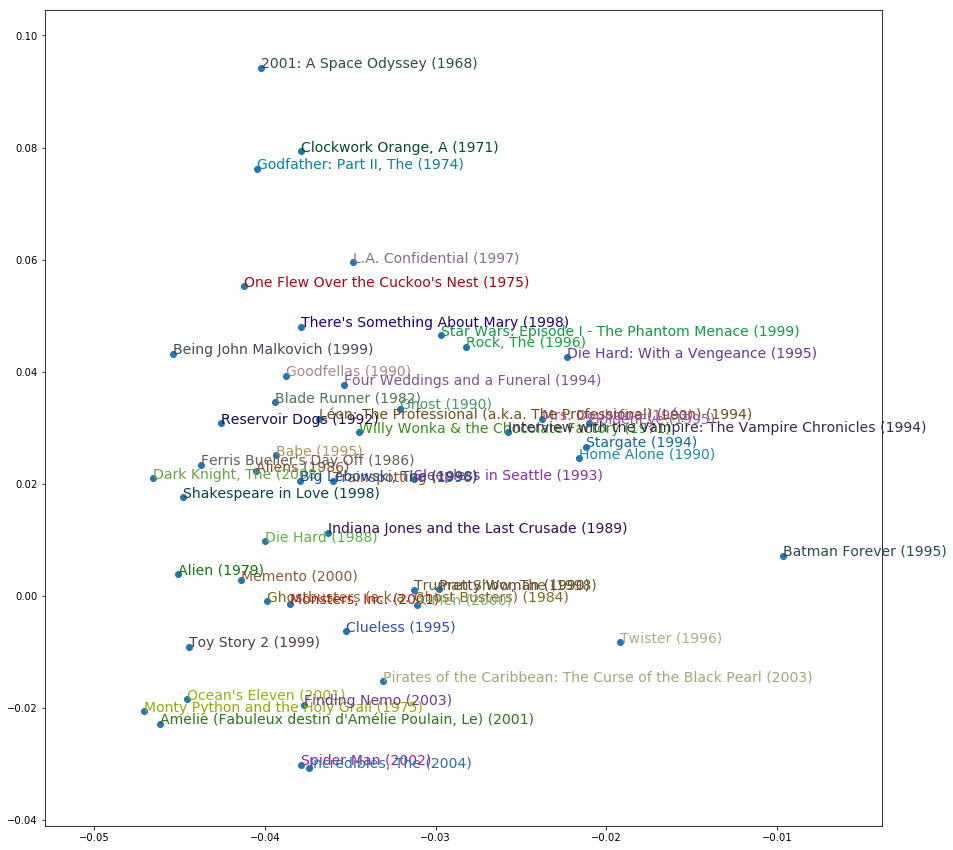

In [63]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [64]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [65]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [66]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80024 samples, validate on 19980 samples
Epoch 1/8
80024/80024 [==============================] - 7s - loss: 2.5655 - val_loss: 0.9127
Epoch 2/8
80024/80024 [==============================] - 7s - loss: 1.4982 - val_loss: 0.8466
Epoch 3/8
80024/80024 [==============================] - 7s - loss: 1.2426 - val_loss: 0.8156
Epoch 4/8
80024/80024 [==============================] - 7s - loss: 1.0455 - val_loss: 0.7965
Epoch 5/8
80024/80024 [==============================] - 7s - loss: 0.9170 - val_loss: 0.7870
Epoch 6/8
80024/80024 [==============================] - 7s - loss: 0.8492 - val_loss: 0.7783
Epoch 7/8
80024/80024 [==============================] - 7s - loss: 0.8190 - val_loss: 0.7769
Epoch 8/8
80024/80024 [==============================] - 7s - loss: 0.8077 - val_loss: 0.7798


In [67]:
nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

This improves on our already impressive accuracy even further!